In [3]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.dates as mdates
from datetime import date, timedelta

In [4]:
db_connection = sql.connect(host='localhost', database='collection_users', user='pandas', password='password')

sbItems = pd.read_sql('SELECT * FROM UsersShoeboxItems', con=db_connection)
sbItems['tool_id'] = sbItems['tool_id'].astype('category')
sbItems['extension'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extension'] = sbItems['extension'].astype('category')
sbItems['mimetype'] = sbItems['mimetype'].astype('category')
sbItems['created'] = pd.to_datetime(sbItems['created'], unit='s')
sbItems['lastmodified'] = pd.to_datetime(sbItems['lastmodified'], unit='s')
sbItems['deleted'].replace(0, np.nan, inplace=True)
sbItems['deleted'] = pd.to_datetime(sbItems['deleted'], unit='s')
sbItems['refers_to_uid'] = sbItems['refers_to_uid'].astype(int)
sbItems['fingerprint'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['title'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['description'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret_o'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extras'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)

In [5]:
db_connection = sql.connect(host='localhost', database='collection_visits', user='pandas', password='password')

pensCheckouts = pd.read_sql('SELECT * FROM PensCheckouts', con=db_connection)
pensCheckouts['start'] = pd.to_datetime(pensCheckouts['start'], unit='s')
pensCheckouts['start'].replace(0, np.nan, inplace=True)
pensCheckouts['end'].replace(0, np.nan, inplace=True)
pensCheckouts['end'] = pd.to_datetime(pensCheckouts['end'], unit='s')
pensCheckouts['start_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['end_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['start_ip'] = pensCheckouts['start_ip'].astype('category')
pensCheckouts['end_ip'] = pensCheckouts['end_ip'].astype('category')
pensCheckouts.set_index('id', inplace=True)
pensCheckouts.sort_index(inplace=True)
###DROPED COLUMNS####
pensCheckouts.drop(['start_ip', 'end_ip'], axis=1, inplace=True)

In [6]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option("max_colwidth", 500)

In [9]:
sbItems[sbItems['user_id'] == 0]
#when the most items where collected 

,id,user_id,action_id,tool_id,bundle_id,refers_to_id,refers_to_uid,fingerprint,title,description,secret,extension,mimetype,is_public,created,lastmodified,deleted,secret_o,extras,status_id,processed,input_id


In [6]:
sbItems.nunique()
#75,428 unique items. if it's by 'refer_to_uid'

id               1555921
user_id            23681
action_id              2
tool_id               15
bundle_id          22589
refers_to_id           6
refers_to_uid      75428
fingerprint        20910
title               1971
description          393
secret             22752
extension              6
mimetype              10
is_public              2
created           955050
lastmodified      211013
deleted            15851
secret_o           22752
extras             21551
status_id              3
processed           1050
input_id               4
dtype: int64

In [7]:
sbItems['refers_to_uid'].value_counts().nlargest(100)
#the most collected items

18703475     4362
18703477     4256
18703473     4159
18703503     3942
35460287     3633
18703485     3514
18703481     3489
69192475     2956
18733333     2942
18187831     2907
18703479     2891
35460437     2739
69155331     2713
18703483     2556
69172097     2462
69172091     2462
69172093     2460
69172085     2459
404529347    2459
69172095     2459
404529351    2458
102335187    2458
102335185    2457
69172077     2457
69172087     2457
102335183    2457
69172089     2455
404529341    2455
404529339    2455
404529329    2454
69172081     2453
404529319    2453
404529303    2453
404529313    2453
404529333    2452
420565501    2452
404529305    2452
404529331    2452
404529321    2452
404529335    2451
404529337    2451
404529315    2451
404529325    2451
404529311    2450
404529301    2450
404529307    2450
404529317    2450
404529343    2449
404529323    2448
404529349    2416
35460289     2386
18699461     2381
69155335     2347
18187781     2276
18187025     2268
18312379  

In [8]:
sbItems_by_month = sbItems['created'].groupby(sbItems.created.dt.to_period("M")).agg('count')
sbItems_by_month.nlargest(10)

created
2016-03    114784
2016-04     99157
2016-05     86667
2016-02     79083
2016-06     72890
2016-07     72756
2015-10     55846
2015-08     55648
2015-12     48550
2016-08     45025
Freq: M, Name: created, dtype: int64

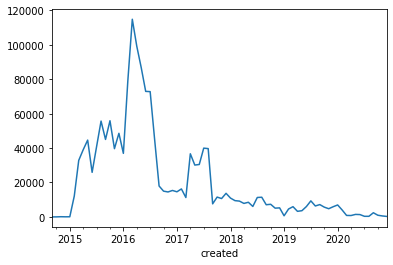

In [9]:
sbItems_by_month.plot()

# sbItems and exhibition

In [10]:
url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.exhibitions.getList&access_token=729cca8ffeb40cd2e725f5301e034134'
resp = requests.request('GET', url)
exhibition = json.loads(resp.text)
exhibition = pd.json_normalize(exhibition['exhibitions'])
exhibition['date_start'] = pd.to_datetime(exhibition['date_start'])
exhibition['date_end'].replace('0000-00-00', '2020-12-30', inplace=True)
exhibition['date_end'] = pd.to_datetime(exhibition['date_end'])
##filtering by the pens dates
exhibition= exhibition[exhibition['date_start'] >= '2014-01-01']

In [11]:
def exhibition_sbItems(onesb):
    start = onesb >= exhibition['date_start']
    end =  onesb <= exhibition['date_end']
    return list(exhibition[start & end]['title'])
    
    
results = sbItems['created'].apply(exhibition_sbItems)
# results.to_csv('exhibition_in_SBitems.csv', encoding='utf-8', index=False)

In [12]:
results
# results = pd.read_csv('exhibition_in_SBitems.csv')
# results =results['created']
# results

0                                                                                                                                                                                                                                                                                                          []
1                                                                                                                                                                                                                                                                                                          []
2                                                                                                                                                                                                                                                                                                          []
3                                                                                             

In [13]:
sbItems['exhibition_info'] = results

In [14]:
sbItems_clean = sbItems.drop(['extras', 'status_id', 'processed', 'input_id', 'extension', 'title', 'description'], axis=1)

In [15]:
sbItems_clean

,id,user_id,action_id,tool_id,bundle_id,refers_to_id,refers_to_uid,fingerprint,secret,mimetype,is_public,created,lastmodified,deleted,secret_o,exhibition_info
0,789443,199,2,0,789383,0,0,e6c8ee7e3c4d75c6292befc26c24dc884db71cd4,UqbTQrnbo5BV,image/png,0,2014-09-30 20:16:24,2014-09-30 20:38:58,NaT,UqbTQrnbo5BV,[]
1,789513,199,2,0,789383,0,0,19260472a130fd3dce2671a3233cedf207729992,ARfJNtmR27n6,image/svg+xml,0,2014-09-30 20:40:41,2014-09-30 20:40:41,NaT,ARfJNtmR27n6,[]
2,789969,231,1,0,789967,1,18706081,NaN,NaN,type/prs.hyperlink,0,2014-10-02 19:59:12,2014-10-02 21:43:36,NaT,NaN,[]
3,789989,231,1,0,789967,1,18771063,NaN,NaN,type/prs.hyperlink,0,2014-10-02 21:24:34,2014-10-02 21:43:36,NaT,NaN,[]
4,789991,231,1,0,789967,1,18630089,NaN,NaN,type/prs.hyperlink,0,2014-10-02 19:59:41,2014-10-02 21:43:36,NaT,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555916,133773815,31324,1,0,0,1,68731025,NaN,NaN,type/prs.hyperlink,0,2020-12-22 20:13:26,2020-12-22 20:13:26,NaT,NaN,"[Willi Smith: Street Couture, Contemporary Muslim Fashions, Botanical Expressions, Herbert Bayer: Bauhaus Master, After Icebergs, Nature by Design: Cochineal, Face Values: Exploring Artificial Intelligence, Collection Selects: Wyss Institute, Plastics, Botanical Lessons, Bathing Beautiful]"
1555917,133773817,31324,1,0,0,1,18350853,NaN,NaN,type/prs.hyperlink,0,2020-12-22 20:13:35,2020-12-22 20:13:35,NaT,NaN,"[Willi Smith: Street Couture, Contemporary Muslim Fashions, Botanical Expressions, Herbert Bayer: Bauhaus Master, After Icebergs, Nature by Design: Cochineal, Face Values: Exploring Artificial Intelligence, Collection Selects: Wyss Institute, Plastics, Botanical Lessons, Bathing Beautiful]"
1555918,133773819,31324,1,0,0,1,18565399,NaN,NaN,type/prs.hyperlink,0,2020-12-22 20:13:42,2020-12-22 20:13:42,NaT,NaN,"[Willi Smith: Street Couture, Contemporary Muslim Fashions, Botanical Expressions, Herbert Bayer: Bauhaus Master, After Icebergs, Nature by Design: Cochineal, Face Values: Exploring Artificial Intelligence, Collection Selects: Wyss Institute, Plastics, Botanical Lessons, Bathing Beautiful]"
1555919,133773825,31325,1,0,0,1,18489513,NaN,NaN,type/prs.hyperlink,0,2020-12-22 20:53:09,2020-12-22 20:53:09,NaT,NaN,"[Willi Smith: Street Couture, Contemporary Muslim Fashions, Botanical Expressions, Herbert Bayer: Bauhaus Master, After Icebergs, Nature by Design: Cochineal, Face Values: Exploring Artificial Intelligence, Collection Selects: Wyss Institute, Plastics, Botanical Lessons, Bathing Beautiful]"


In [16]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

to_1D(sbItems_clean['exhibition_info']).value_counts()

Hewitt Sisters Collect                                                                          1347057
Making Design                                                                                   1047361
Pixar: The Design of Story                                                                       745954
Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest                             566056
Beauty—Cooper Hewitt Design Triennial                                                            553786
Passion for the Exotic: Lockwood de Forest, Frederic Church                                      549920
Thom Browne Selects                                                                              513908
Making Design: Recent Acquisitions                                                               457432
How Posters Work                                                                                 401084
Energizing the Everyday: Gifts From the George R. Kravis II Coll

In [60]:
sbItems_clean.sample(100)

,id,user_id,action_id,tool_id,bundle_id,refers_to_id,refers_to_uid,fingerprint,secret,mimetype,is_public,created,lastmodified,deleted,secret_o,exhibition_info
1347614,120003759,22284,1,0,120000421,1,907219037,NaN,NaN,type/prs.hyperlink,0,2017-10-30 17:11:49,2017-11-01 15:05:56,NaT,NaN,"['Hear, See, Play: Designing with Sound', 'Ilonka Karasz, Works from the Collection', 'Joris Laarman Lab: Design in the Digital Age', 'Passion for the Exotic: Japonism', 'The Virtue in Vice', 'Esperanza Spalding Selects', 'Making | Breaking: New Arrivals']"
1090261,110442487,16905,1,0,110440517,1,420556757,NaN,NaN,type/prs.hyperlink,0,2016-11-22 16:01:03,2016-11-27 19:29:48,NaT,NaN,"['Ellen DeGeneres Selects', 'Process Lab: Citizen Design', 'By the People: Designing a Better America', 'Scraps', 'Fragile Beasts', 'Energizing the Everyday: Gifts From the George R. Kravis II Collection', 'Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest', 'Hewitt Sisters Collect']"
1113848,111629205,17655,1,0,111627349,1,18488153,NaN,NaN,type/prs.hyperlink,0,2017-01-07 16:55:48,2017-01-20 01:02:00,NaT,NaN,"['Ellen DeGeneres Selects', 'Process Lab: Citizen Design', 'By the People: Designing a Better America', 'Scraps', 'Fragile Beasts', 'Energizing the Everyday: Gifts From the George R. Kravis II Collection', 'Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest', 'Hewitt Sisters Collect']"
980498,105087641,14954,1,0,105067539,1,18661473,NaN,NaN,type/prs.hyperlink,0,2016-07-21 19:11:21,2016-07-22 21:18:34,NaT,NaN,"['Fragile Beasts', 'Energizing the Everyday: Gifts From the George R. Kravis II Collection', 'Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest', 'Thom Browne Selects', 'Beauty—Cooper Hewitt Design Triennial', 'Pixar: The Design of Story', 'Hewitt Sisters Collect', 'Making Design']"
827889,100545085,13274,1,0,100533317,1,69193883,NaN,NaN,type/prs.hyperlink,1,2016-05-21 20:28:41,2016-05-22 15:29:26,NaT,NaN,"['Energizing the Everyday: Gifts From the George R. Kravis II Collection', 'Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest', 'Thom Browne Selects', 'Beauty—Cooper Hewitt Design Triennial', 'Making Design: Recent Acquisitions', 'Pixar: The Design of Story', 'Hewitt Sisters Collect', 'Making Design']"
1495998,128419987,28751,1,0,128417479,1,2318793581,NaN,NaN,type/prs.hyperlink,0,2019-06-30 15:07:19,2019-06-30 18:42:14,NaT,NaN,"['Plastics', 'Botanical Lessons', 'Bathing Beautiful', 'Nature—Cooper Hewitt Design Triennial', 'Paisley', 'Embroidered and Embellished', 'Katagami', 'Process Lab: Scholten & Baijings', 'Iridescence']"
470348,92638099,9051,1,0,0,1,136252329,NaN,NaN,type/prs.hyperlink,0,2016-01-19 01:00:55,2016-01-19 01:00:55,NaT,NaN,"['Making Design: Recent Acquisitions', 'Pixar: The Design of Story', 'David Adjaye Selects: Works from the Permanent Collection', 'Hewitt Sisters Collect', 'Making Design', 'Passion for the Exotic: Lockwood de Forest, Frederic Church']"
1344761,119888979,22153,1,0,119885993,1,18710623,NaN,NaN,type/prs.hyperlink,0,2017-10-24 18:48:10,2017-10-25 00:19:35,NaT,NaN,"['Hear, See, Play: Designing with Sound', 'Ilonka Karasz, Works from the Collection', 'Joris Laarman Lab: Design in the Digital Age', 'Passion for the Exotic: Japonism', 'The Virtue in Vice', 'Esperanza Spalding Selects', 'Making | Breaking: New Arrivals', 'Hewitt Sisters Collect']"
531324,94055063,9937,1,0,94027021,1,18758437,NaN,NaN,type/prs.hyperlink,0,2016-02-21 21:07:11,2016-02-22 13:41:24,NaT,NaN,"['Beauty—Cooper Hewitt Design Triennial', 'Making Design: Recent Acquisitions', 'Pixar: The Design of Story', 'Hewitt Sisters Collect', 'Making Design', 'Passion for the Exotic: Lockwood de Forest, Frederic Church']"
825466,100483857,13244,1,0,100476377,1,136253089,NaN,NaN,type/prs.hyperlink,0,2016-05-21 15:43:01,2016-05-21 20:43:56,NaT,NaN,"['Energizing the Everyday: Gifts From the George R. Kravis II Collection', 'Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest', 'T

Text(0.5, 1.0, 'The exhibitions by shoe box items')

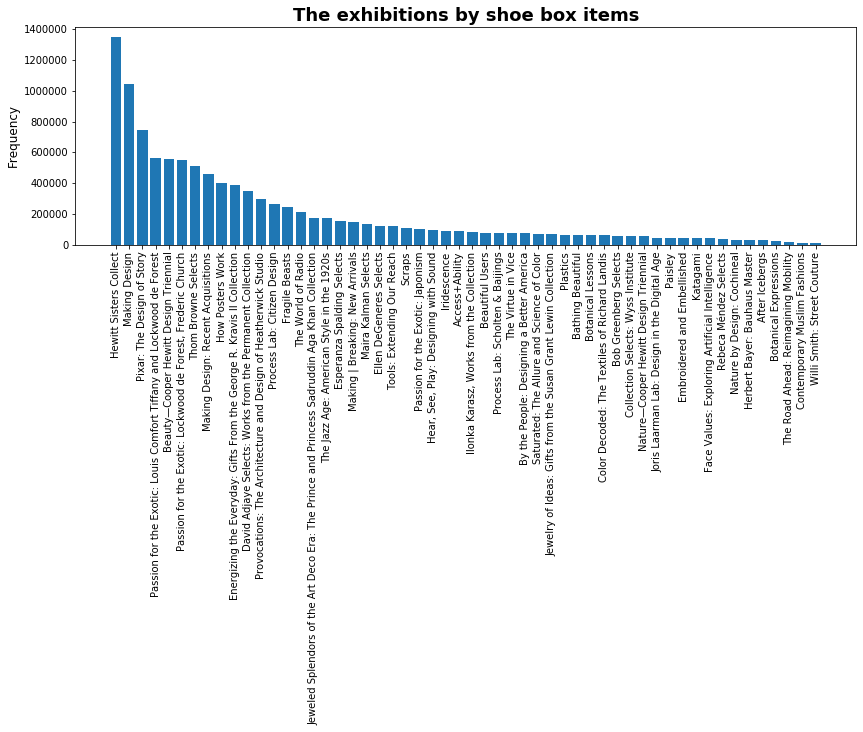

In [17]:
fig, ax = plt.subplots(figsize = (14,4))
ax.bar(to_1D(sbItems_clean['exhibition_info']).value_counts().index,
        to_1D(sbItems_clean['exhibition_info']).value_counts().values)
plt.xticks(rotation=90)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Exhibition Title", size = 14)
plt.title('The exhibitions by shoe box items', fontdict={'fontweight': 'bold', 'fontsize':18})
# plt.savefig('exhibition_sbItems.png', dpi=300)

# post engagment

In [12]:
sbItems.nunique()

id               1555921
user_id            23681
action_id              2
tool_id               15
bundle_id          22589
refers_to_id           6
refers_to_uid      75428
fingerprint        20910
title               1971
description          393
secret             22752
extension              6
mimetype              10
is_public              2
created           955050
lastmodified      211013
deleted            15851
secret_o           22752
extras             21551
status_id              3
processed           1050
input_id               4
dtype: int64

In [13]:
#how many of the users are associated with secret
sbItemsNan = sbItems[~pd.isnull(sbItems['secret'])]
sbItemsNan.nunique()

id               22752
user_id           7287
action_id            1
tool_id             15
bundle_id         7763
refers_to_id         2
refers_to_uid    22732
fingerprint      20910
title              150
description         55
secret           22752
extension            6
mimetype             9
is_public            2
created          22746
lastmodified     18532
deleted            293
secret_o         22752
extras           21551
status_id            1
processed          115
input_id             2
dtype: int64

In [14]:
#how many users in total
id_count = sbItems['user_id'].value_counts().count()
#how many users in secret that are not NAN
secret_id = sbItemsNan['user_id'].value_counts().count()

(secret_id/id_count)*100
#there is a 30.7% percentage of visitors that have secrets -> post engagment. 

30.771504581732188

In [15]:
sbItems_by_month = sbItems['created'].groupby(sbItems.created.dt.to_period("M")).agg('count')
sbItems_by_month.nlargest(10)
#what monthsdid it happen the most?

created
2016-03    114784
2016-04     99157
2016-05     86667
2016-02     79083
2016-06     72890
2016-07     72756
2015-10     55846
2015-08     55648
2015-12     48550
2016-08     45025
Freq: M, Name: created, dtype: int64

In [16]:
#how many unique users in not NaN secret
sbItemsunique= sbItemsNan[~sbItemsNan['user_id'].duplicated()]
#how many unique users
sbItemsid= sbItems[~sbItems['user_id'].duplicated()]
sbItemsid

,id,user_id,action_id,tool_id,bundle_id,refers_to_id,refers_to_uid,fingerprint,title,description,secret,extension,mimetype,is_public,created,lastmodified,deleted,secret_o,extras,status_id,processed,input_id
0,789443,199,2,0,789383,0,0,e6c8ee7e3c4d75c6292befc26c24dc884db71cd4,NaN,NaN,UqbTQrnbo5BV,png,image/png,0,2014-09-30 20:16:24,2014-09-30 20:38:58,NaT,UqbTQrnbo5BV,NaN,0,0,0
2,789969,231,1,0,789967,1,18706081,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,0,2014-10-02 19:59:12,2014-10-02 21:43:36,NaT,NaN,NaN,0,0,0
7,790373,247,2,8,790365,1,18731913,e612768311e890008508d5feb8cbdc2fda3167c4,NaN,NaN,qCt9zLY122sJ,obj,application/octet-stream,0,2014-10-06 19:34:33,2015-01-31 04:17:29,2015-01-31 04:17:29,qCt9zLY122sJ,NaN,0,0,0
29,797843,142,1,0,797837,1,18709977,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,0,2014-11-04 20:32:50,2014-11-04 20:36:04,NaT,NaN,NaN,0,0,0
136,1049059,3,1,0,0,1,18649107,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,1,2014-11-17 20:03:47,2015-05-26 14:25:49,NaT,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555840,133756917,31319,1,0,0,1,18386789,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,0,2020-12-19 19:05:08,2020-12-19 19:05:08,NaT,NaN,NaN,0,0,0
1555841,133763415,31321,1,0,0,1,18645651,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,0,2020-12-21 06:43:12,2020-12-21 06:43:12,NaT,NaN,NaN,0,0,0
1555842,133769327,31323,1,0,0,1,18605029,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,0,2020-12-22 04:18:08,2020-12-22 04:18:08,NaT,NaN,NaN,0,0,0
1555843,133770993,31324,1,0,0,1,18168919,NaN,NaN,NaN,NaN,NaN,type/prs.hyperlink,0,2020-12-22 16:30:43,2020-12-22 16:30:43,NaT,NaN,NaN,0,0,0


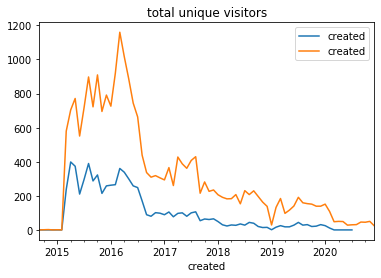

In [26]:
sbItems_engagment = sbItemsunique['created'].groupby(sbItemsunique.created.dt.to_period('M')).agg('count')
sbItemsid_vists = sbItemsid['created'].groupby(sbItemsid.created.dt.to_period('M')).agg('count')
sbItems_engagment.plot(title='unique visitors that visit online')
sbItemsid_vists.plot(title='total unique visitors')
plt.legend()
#the number of unique users using the pen vs the number of unique ppl visiting online

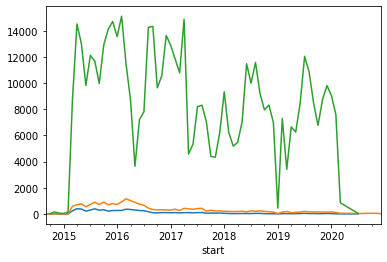

In [27]:
pensCheckouts_month = pensCheckouts['start'].groupby(pensCheckouts.start.dt.to_period('M')).agg('count')
sbItems_engagment.plot()
sbItemsid_vists.plot()
pensCheckouts_month.plot()
#including checkouts - to see the relation... 